# 3. EDD V1

Operation A: Scheduled from 0 to 3 on machine M1 in workcenter WC#1
Operation B: Scheduled from 0 to 5 on machine M2 in workcenter WC#1
Operation C: Scheduled from 0 to 2 on machine M1 in workcenter WC#2
Operation D: Scheduled from 0 to 4 on machine M2 in workcenter WC#2
Operation E: Scheduled from 3 to 4 on machine M3 in workcenter WC#3
Operation F: Scheduled from 5 to 7 on machine M4 in workcenter WC#3
Operation G: Scheduled from 2 to 5 on machine M1 in workcenter WC#1
Operation H: Scheduled from 4 to 9 on machine M2 in workcenter WC#1
Operation I: Scheduled from 4 to 8 on machine M1 in workcenter WC#2
Operation J: Scheduled from 7 to 10 on machine M2 in workcenter WC#2
Operation K: Scheduled from 5 to 7 on machine M3 in workcenter WC#3
Operation L: Scheduled from 9 to 10 on machine M4 in workcenter WC#3
Operation M: Scheduled from 8 to 14 on machine M1 in workcenter WC#1
Operation N: Scheduled from 10 to 15 on machine M2 in workcenter WC#1
Operation O: Scheduled from 7 to 10 on mach

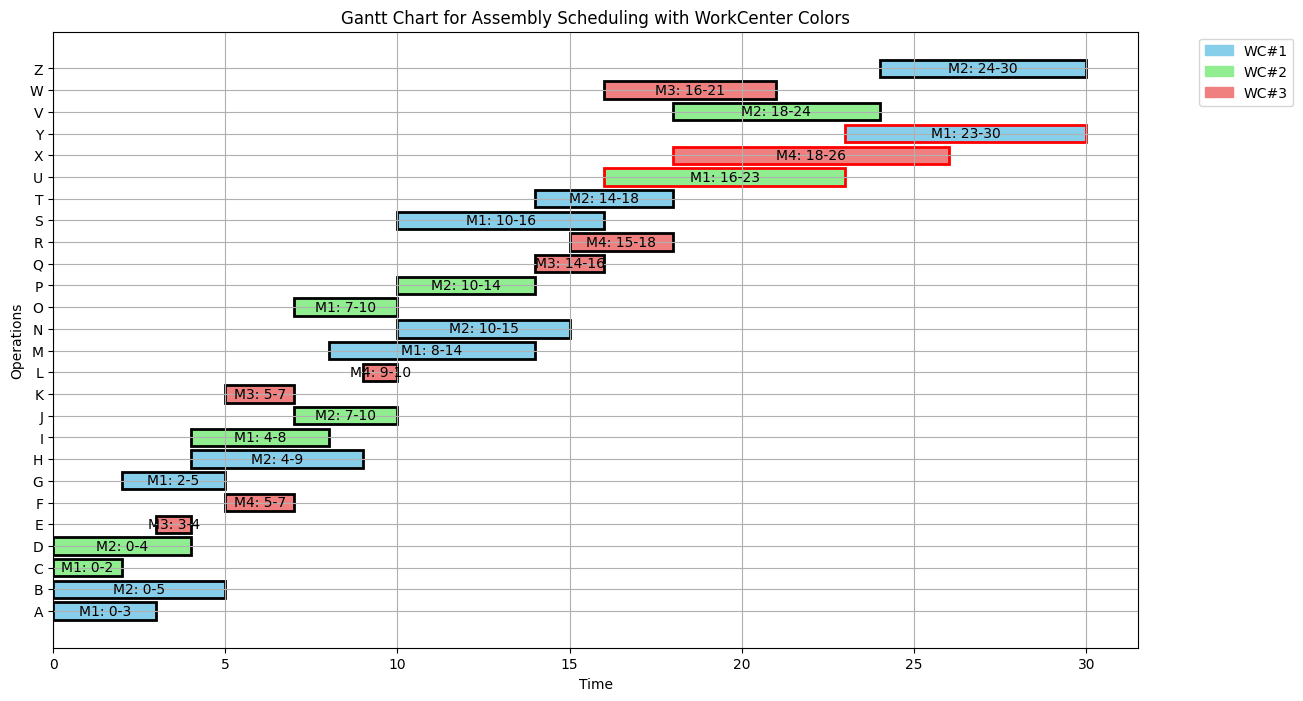

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the Operation class
class Operation:
    def __init__(self, id, processing_time, workcenter, machine, components_required, end_product, due_date):
        self.id = id
        self.processing_time = processing_time
        self.workcenter = workcenter
        self.machine = machine
        self.components_required = components_required if components_required else []
        self.end_product = end_product
        self.due_date = due_date
        self.start_time = None
        self.end_time = None
        self.scheduled = False

# Define the WorkCenter class
class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines

# Create BOM DataFrame
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
    'components_required': ['[]', '[]', '[]', '[]', "['A']", "['B']", "['C']", "['D']", "['E']", "['F']", "['G']", "['H']", "['I']", "['J']", "['K']", "['L']", "['M']", "['N']", "['O']", "['P']", "['Q']", "['R']", "['S']", "['T']", "['U']", "['V']"],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    'due_date': [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 10, 30, 30, 20, 20, 40],
    'processing_time': [3, 5, 2, 4, 1, 2, 3, 5, 4, 3, 2, 1, 6, 5, 3, 4, 2, 3, 6, 4, 7, 6, 5, 8, 7, 6],
    'workcenter': ['WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1'],
    'machine': ['M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2']
})

df_machine = pd.DataFrame({
    'workcenter': ['WC#1', 'WC#2', 'WC#3'],
    'M1': [3, 2, 2],
    'M2': [2, 1, 1],
    'M3': [1, 1, 1],
    'M4': [1, 1, 1]
})

factory = {}
for idx, row in df_machine.iterrows():
    workcenter = row['workcenter']
    dict_machines = {}
    for machine in df_machine.columns[1:]: 
        dict_machines[machine] = [[] for _ in range(row[machine])]
    factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)

def load_operations_from_df(df):
    operations = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        components_required = eval(row['components_required'])  # Convert string representation of list to list
        operations[operation_id] = Operation(
            operation_id,
            row['processing_time'],
            row['workcenter'],
            row['machine'],
            components_required,
            row['end_product'],
            row['due_date']
        )
    return operations

# Helper function to find the earliest available time slot for a machine
def find_earliest_time_slot(machine_usage, processing_time):
    if not machine_usage:
        return 0
    for i, (start, end) in enumerate(machine_usage):
        if i == 0 and start >= processing_time:
            return 0
        if i < len(machine_usage) - 1 and machine_usage[i + 1][0] - end >= processing_time:
            return end
    return machine_usage[-1][1]

def schedule_operations(operations):
    scheduled_operations = []
    Q = [op_id for op_id, op in operations.items() if not op.components_required]  # Operations without predecessors

    while Q:
        Q.sort(key=lambda op_id: operations[op_id].due_date if operations[op_id].due_date is not None else float('inf'))
        operation_id = Q.pop(0)
        operation = operations[operation_id]

        if operation.components_required:
            max_end_time = max(operations[comp_id].end_time for comp_id in operation.components_required)
            operation.start_time = max_end_time
        else:
            operation.start_time = 0

        workcenter = factory[operation.workcenter]
        machine_usage = workcenter.machines[operation.machine]
        best_start_time = float('inf')
        selected_machine = None
        for machine in machine_usage:
            start_time = max(operation.start_time, find_earliest_time_slot(machine, operation.processing_time))
            if start_time < best_start_time:
                best_start_time = start_time
                selected_machine = machine

        operation.start_time = best_start_time
        operation.end_time = operation.start_time + operation.processing_time
        selected_machine.append((operation.start_time, operation.end_time))
        selected_machine.sort()

        operation.scheduled = True
        scheduled_operations.append(operation)
        
        # Debug information
        print(f"Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {operation.machine} in workcenter {operation.workcenter}")

        # Add dependent operations to the queue
        for op_id, op in operations.items():
            if not op.scheduled and all(operations[comp_id].scheduled for comp_id in op.components_required) and op_id not in Q:
                Q.append(op_id)

    return scheduled_operations

def plot_gantt_chart(scheduled_operations):
    # Define color mappings
    workcenter_colors = {
        'WC#1': 'skyblue',
        'WC#2': 'lightgreen',
        'WC#3': 'lightcoral'
    }

    fig, ax = plt.subplots(figsize=(14, 8))
    for op in scheduled_operations:
        wc_color = workcenter_colors.get(op.workcenter, 'gray')
        edge_color = 'red' if op.due_date and op.end_time > op.due_date else 'black'
        ax.barh(op.id, op.processing_time, left=op.start_time, color=wc_color, edgecolor=edge_color, linewidth=2)
        ax.text(op.start_time + op.processing_time / 2, op.id, f'{op.machine}: {op.start_time}-{op.end_time}', ha='center', va='center', color='black')

    # Add legend
    workcenter_patches = [mpatches.Patch(color=color, label=wc) for wc, color in workcenter_colors.items()]
    plt.legend(handles=workcenter_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.set_title('Gantt Chart for Assembly Scheduling with WorkCenter Colors')
    plt.grid(True)
    plt.show()

# Load operations from the BOM dataframe
operations = load_operations_from_df(df_BOM)

# Schedule operations
scheduled_operations = schedule_operations(operations)
for op in scheduled_operations:
    print(f"Operation {op.id}: Start Time = {op.start_time}, End Time = {op.end_time}")

# Plot the Gantt chart
plot_gantt_chart(scheduled_operations)


Operation A: Scheduled from 0 to 3 on machine M1 in workcenter WC#1
Operation C: Scheduled from 0 to 2 on machine M1 in workcenter WC#2
Operation D: Scheduled from 0 to 4 on machine M2 in workcenter WC#2
Operation D: Scheduled from 4 to 8 on machine M2 in workcenter WC#2
Operation B: Scheduled from 0 to 5 on machine M2 in workcenter WC#1
Operation G: Scheduled from 2 to 5 on machine M1 in workcenter WC#1
Operation H: Scheduled from 8 to 13 on machine M2 in workcenter WC#1
Operation B: Scheduled from 0 to 5 on machine M2 in workcenter WC#1
Operation F: Scheduled from 5 to 7 on machine M4 in workcenter WC#3
Operation K: Scheduled from 5 to 7 on machine M3 in workcenter WC#3
Operation L: Scheduled from 13 to 14 on machine M4 in workcenter WC#3
Operation B: Scheduled from 5 to 10 on machine M2 in workcenter WC#1
Operation J: Scheduled from 8 to 11 on machine M2 in workcenter WC#2
Operation O: Scheduled from 7 to 10 on machine M1 in workcenter WC#2
Operation P: Scheduled from 14 to 18 on ma

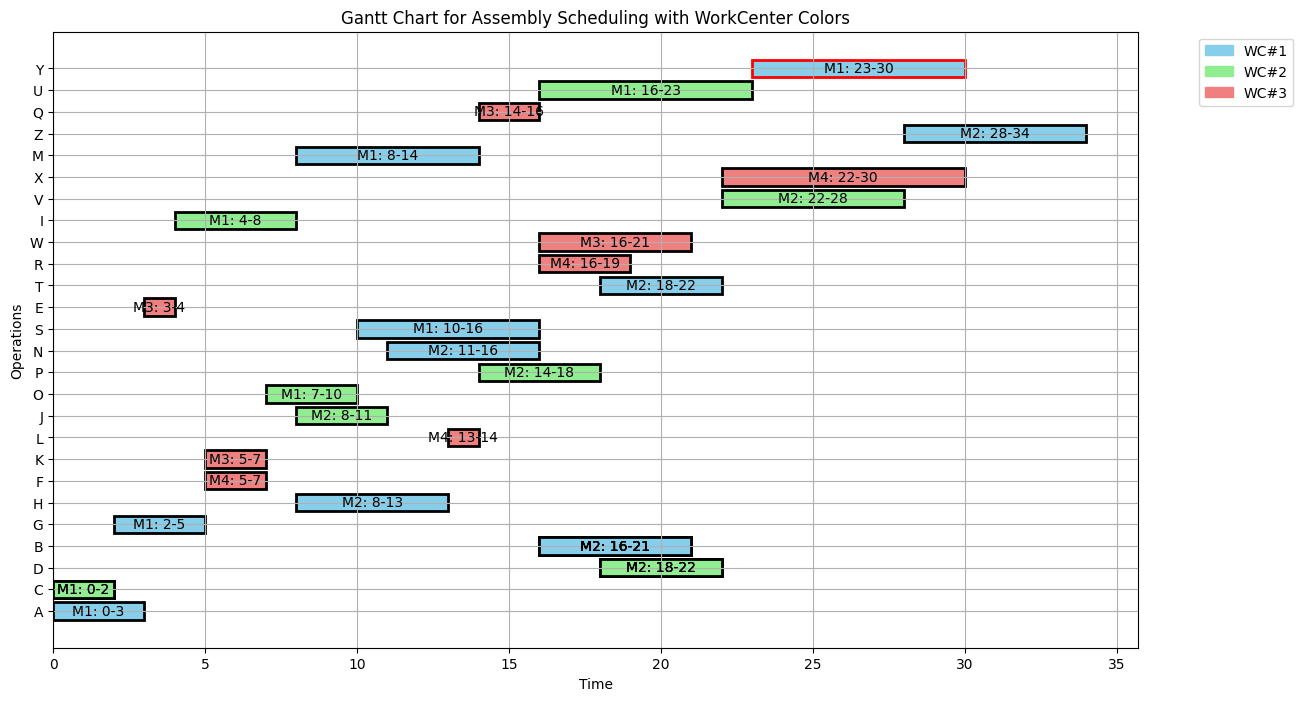

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import heapq

# Define the Operation class
class Operation:
    def __init__(self, id, processing_time, workcenter, machine, components_required, end_product, due_date):
        self.id = id
        self.processing_time = processing_time
        self.workcenter = workcenter
        self.machine = machine
        self.components_required = components_required if components_required else []
        self.end_product = end_product
        self.due_date = due_date
        self.start_time = None
        self.end_time = None
        self.scheduled = False

# Define the WorkCenter class
class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines

# Create BOM DataFrame
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
    'components_required': ['[]', '[]', '[]', '[]', "['A']", "['B']", "['C']", "['D']", "['E']", "['F']", "['G']", "['H']", "['I']", "['J']", "['K']", "['L']", "['M']", "['N']", "['O']", "['P']", "['Q']", "['R']", "['S']", "['T']", "['U']", "['V']"],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    'due_date': [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 80, 30, 30, 40, 20, 40],
    'processing_time': [3, 5, 2, 4, 1, 2, 3, 5, 4, 3, 2, 1, 6, 5, 3, 4, 2, 3, 6, 4, 7, 6, 5, 8, 7, 6],
    'workcenter': ['WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1'],
    'machine': ['M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2']
})

df_machine = pd.DataFrame({
    'workcenter': ['WC#1', 'WC#2', 'WC#3'],
    'M1': [3, 2, 2],
    'M2': [2, 1, 1],
    'M3': [1, 1, 1],
    'M4': [1, 1, 1]
})

factory = {}
for idx, row in df_machine.iterrows():
    workcenter = row['workcenter']
    dict_machines = {}
    for machine in df_machine.columns[1:]: 
        dict_machines[machine] = [[] for _ in range(row[machine])]
    factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)

def load_operations_from_df(df):
    operations = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        components_required = eval(row['components_required'])  # Convert string representation of list to list
        operations[operation_id] = Operation(
            operation_id,
            row['processing_time'],
            row['workcenter'],
            row['machine'],
            components_required,
            row['end_product'],
            row['due_date']
        )
    return operations

# Helper function to find the earliest available time slot for a machine
def find_earliest_time_slot(machine_usage, processing_time):
    if not machine_usage:
        return 0
    for i, (start, end) in enumerate(machine_usage):
        if i == 0 and start >= processing_time:
            return 0
        if i < len(machine_usage) - 1 and machine_usage[i + 1][0] - end >= processing_time:
            return end
    return machine_usage[-1][1]

def schedule_operations(operations):
    scheduled_operations = []
    Q = []
    unscheduled_dependencies = {op_id: len(op.components_required) for op_id, op in operations.items()}
    
    # Initialize the queue with operations that have no dependencies
    for op_id, count in unscheduled_dependencies.items():
        if count == 0:
            heapq.heappush(Q, (operations[op_id].due_date if operations[op_id].due_date is not None else float('inf'), operations[op_id].processing_time, op_id))

    while Q:
        _, _, operation_id = heapq.heappop(Q)
        operation = operations[operation_id]

        if operation.components_required:
            max_end_time = max(operations[comp_id].end_time for comp_id in operation.components_required)
            operation.start_time = max_end_time
        else:
            operation.start_time = 0

        workcenter = factory[operation.workcenter]
        machine_usage = workcenter.machines[operation.machine]
        best_start_time = float('inf')
        selected_machine = None
        for machine in machine_usage:
            start_time = max(operation.start_time, find_earliest_time_slot(machine, operation.processing_time))
            if start_time < best_start_time:
                best_start_time = start_time
                selected_machine = machine

        operation.start_time = best_start_time
        operation.end_time = operation.start_time + operation.processing_time
        selected_machine.append((operation.start_time, operation.end_time))
        selected_machine.sort()

        operation.scheduled = True
        scheduled_operations.append(operation)
        
        # Debug information
        print(f"Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {operation.machine} in workcenter {operation.workcenter}")

        # Update dependencies and add ready operations to the queue
        for op_id, op in operations.items():
            if not op.scheduled and op_id in unscheduled_dependencies:
                for comp_id in op.components_required:
                    if operations[comp_id].scheduled:
                        unscheduled_dependencies[op_id] -= 1
                if unscheduled_dependencies[op_id] == 0:
                    heapq.heappush(Q, (op.due_date if op.due_date is not None else float('inf'), op.processing_time, op_id))

    return scheduled_operations

def plot_gantt_chart(scheduled_operations):
    # Define color mappings
    workcenter_colors = {
        'WC#1': 'skyblue',
        'WC#2': 'lightgreen',
        'WC#3': 'lightcoral'
    }

    fig, ax = plt.subplots(figsize=(14, 8))
    for op in scheduled_operations:
        wc_color = workcenter_colors.get(op.workcenter, 'gray')
        edge_color = 'red' if op.due_date and op.end_time > op.due_date else 'black'
        ax.barh(op.id, op.processing_time, left=op.start_time, color=wc_color, edgecolor=edge_color, linewidth=2)
        ax.text(op.start_time + op.processing_time / 2, op.id, f'{op.machine}: {op.start_time}-{op.end_time}', ha='center', va='center', color='black')

    # Add legend
    workcenter_patches = [mpatches.Patch(color=color, label=wc) for wc, color in workcenter_colors.items()]
    plt.legend(handles=workcenter_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.set_title('Gantt Chart for Assembly Scheduling with WorkCenter Colors')
    plt.grid(True)
    plt.show()

# Load operations from the BOM dataframe
operations = load_operations_from_df(df_BOM)

# Schedule operations
scheduled_operations = schedule_operations(operations)
for op in scheduled_operations:
    print(f"Operation {op.id}: Start Time = {op.start_time}, End Time = {op.end_time}")

# Plot the Gantt chart
plot_gantt_chart(scheduled_operations)


Operation A: Scheduled from 0 to 3 on machine M1 in workcenter WC#1
Operation C: Scheduled from 0 to 2 on machine M1 in workcenter WC#2
Operation D: Scheduled from 0 to 4 on machine M1 in workcenter WC#2
Operation D: Scheduled from 0 to 4 on machine M2 in workcenter WC#2
Operation B: Scheduled from 0 to 5 on machine M1 in workcenter WC#1
Operation G: Scheduled from 2 to 5 on machine M1 in workcenter WC#1
Operation H: Scheduled from 4 to 9 on machine M1 in workcenter WC#1
Operation B: Scheduled from 0 to 5 on machine M2 in workcenter WC#1
Operation F: Scheduled from 5 to 7 on machine M1 in workcenter WC#3
Operation K: Scheduled from 5 to 7 on machine M1 in workcenter WC#3
Operation L: Scheduled from 9 to 10 on machine M1 in workcenter WC#3
Operation B: Scheduled from 0 to 5 on machine M2 in workcenter WC#1
Operation J: Scheduled from 7 to 10 on machine M1 in workcenter WC#2
Operation O: Scheduled from 7 to 10 on machine M1 in workcenter WC#2
Operation P: Scheduled from 10 to 14 on machi

C:\Users\natha\AppData\Local\Temp\ipykernel_17032\2904701917.py:175: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(mpatches.Rectangle((operation.start_time, 0), operation.processing_time, 1,


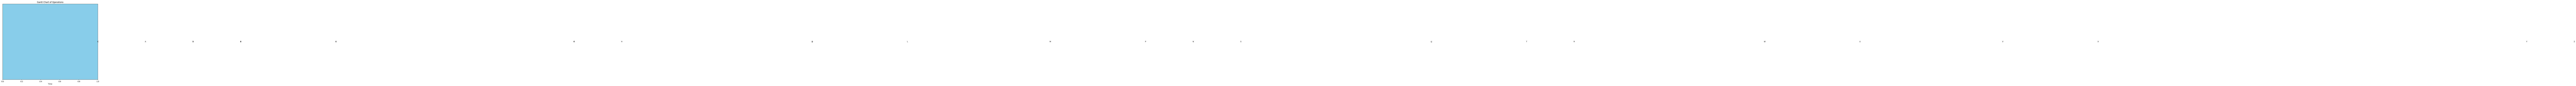

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import heapq

# Define the Operation class
class Operation:
    def __init__(self, id, processing_time, workcenter, machine, components_required, end_product, due_date):
        self.id = id
        self.processing_time = processing_time
        self.workcenter = workcenter
        self.machine = machine
        self.components_required = components_required if components_required else []
        self.end_product = end_product
        self.due_date = due_date
        self.start_time = None
        self.end_time = None
        self.scheduled = False

# Define the WorkCenter class
class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines

# Create BOM DataFrame
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
    'components_required': ['[]', '[]', '[]', '[]', "['A']", "['B']", "['C']", "['D']", "['E']", "['F']", "['G']", "['H']", "['I']", "['J']", "['K']", "['L']", "['M']", "['N']", "['O']", "['P']", "['Q']", "['R']", "['S']", "['T']", "['U']", "['V']"],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    'due_date': [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 40, 40, 40, 40, 20, 20],
    'processing_time': [3, 5, 2, 4, 1, 2, 3, 5, 4, 3, 2, 1, 6, 5, 3, 4, 2, 3, 6, 4, 7, 6, 5, 8, 7, 6],
    'workcenter': ['WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1'],
    'machine': ['M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2']
})

df_machine = pd.DataFrame({
    'workcenter': ['WC#1', 'WC#2', 'WC#3'],
    'M1': [3, 2, 2],
    'M2': [2, 1, 1],
    'M3': [1, 1, 1],
    'M4': [1, 1, 1]
})

# Create factory and work centers
factory = {}
for idx, row in df_machine.iterrows():
    workcenter = row['workcenter']
    dict_machines = {}
    for machine in df_machine.columns[1:]:
        dict_machines[machine] = [[] for _ in range(row[machine])]
    factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)

def load_operations_from_df(df):
    operations = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        components_required = eval(row['components_required'])  # Convert string representation of list to list
        operations[operation_id] = Operation(
            operation_id,
            row['processing_time'],
            row['workcenter'],
            row['machine'],
            components_required,
            row['end_product'],
            row['due_date']
        )
    return operations

def find_earliest_start_time(machine_usage, start_time, processing_time):
    """
    Finds the earliest start time on the given machine that avoids overlapping with existing jobs.
    """
    machine_usage.sort()
    if not machine_usage:
        return start_time
    
    # Check from the beginning
    for i, (interval_start, interval_end) in enumerate(machine_usage):
        if i == 0 and start_time + processing_time <= interval_start:
            return start_time
        if i > 0 and machine_usage[i-1][1] <= start_time and start_time + processing_time <= interval_start:
            return start_time
        start_time = max(start_time, interval_end)
    return start_time

def check_availability(start_time, processing_time, machine_usage):
    """
    Returns True if the time interval does not overlap with any intervals in machine_usage, False otherwise.
    """
    end_time = start_time + processing_time
    for interval_start, interval_end in machine_usage:
        if not (end_time <= interval_start or start_time >= interval_end):
            return False
    return True

def schedule_operations(operations):
    scheduled_operations = []
    Q = []
    unscheduled_dependencies = {op_id: len(op.components_required) for op_id, op in operations.items()}
    
    # Initialize the queue with operations that have no dependencies, sorted by due dates
    for op_id, count in unscheduled_dependencies.items():
        if count == 0:
            heapq.heappush(Q, (operations[op_id].due_date if operations[op_id].due_date is not None else float('inf'), operations[op_id].processing_time, op_id))

    while Q:
        _, _, operation_id = heapq.heappop(Q)
        operation = operations[operation_id]

        # Compute start time based on dependencies
        if operation.components_required:
            max_end_time = max(operations[comp_id].end_time for comp_id in operation.components_required)
            operation.start_time = max_end_time
        else:
            operation.start_time = 0

        # Find the best machine and start time
        workcenter = factory[operation.workcenter]
        best_start_time = float('inf')
        selected_machine = None
        selected_machine_name = None
        for machine_name, machine_usages in workcenter.machines.items():
            for machine_usage in machine_usages:
                start_time = find_earliest_start_time(machine_usage, operation.start_time, operation.processing_time)
                if check_availability(start_time, operation.processing_time, machine_usage):
                    if start_time < best_start_time:
                        best_start_time = start_time
                        selected_machine = machine_usage
                        selected_machine_name = machine_name

        if selected_machine is None:
            # No available machine found; push operation back
            heapq.heappush(Q, (operation.due_date if operation.due_date is not None else float('inf'), operation.processing_time, operation_id))
            continue

        # Schedule the operation
        operation.start_time = best_start_time
        operation.end_time = operation.start_time + operation.processing_time
        selected_machine.append((operation.start_time, operation.end_time))
        selected_machine.sort()

        # Debug information
        print(f"Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {selected_machine_name} in workcenter {operation.workcenter}")

        operation.scheduled = True
        scheduled_operations.append(operation)

        # Update dependencies and add ready operations to the queue
        for op_id, op in operations.items():
            if not op.scheduled and op_id in unscheduled_dependencies:
                for comp_id in op.components_required:
                    if operations[comp_id].scheduled:
                        unscheduled_dependencies[op_id] -= 1
                if unscheduled_dependencies[op_id] == 0:
                    heapq.heappush(Q, (op.due_date if op.due_date is not None else float('inf'), op.processing_time, op_id))

    return scheduled_operations

def plot_gantt_chart(scheduled_operations):
    # Define color mappings
    workcenter_colors = {
        'WC#1': 'skyblue',
        'WC#2': 'lightgreen',
        'WC#3': 'lightcoral'
    }

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    for operation in scheduled_operations:
        if operation.start_time is not None and operation.end_time is not None:
            workcenter = factory[operation.workcenter]
            color = workcenter_colors.get(operation.workcenter, 'grey')
            ax.add_patch(mpatches.Rectangle((operation.start_time, 0), operation.processing_time, 1,
                                            color=color, edgecolor='black'))

            # Add operation id as text
            ax.text(operation.start_time + operation.processing_time / 2, 0.5, operation.id,
                    ha='center', va='center', color='black')

    # Format plot
    ax.set_xlabel('Time')
    ax.set_yticks([])
    ax.set_title('Gantt Chart of Operations')
    plt.show()

# Main execution
operations = load_operations_from_df(df_BOM)
scheduled_operations = schedule_operations(operations)
plot_gantt_chart(scheduled_operations)


Operation A: Scheduled from 0 to 3 on machine M1 in workcenter WC#1
Operation C: Scheduled from 0 to 2 on machine M1 in workcenter WC#2
Operation D: Scheduled from 0 to 4 on machine M2 in workcenter WC#2
Operation D: Scheduled from 4 to 8 on machine M2 in workcenter WC#2
Operation B: Scheduled from 0 to 5 on machine M2 in workcenter WC#1
Operation G: Scheduled from 2 to 5 on machine M1 in workcenter WC#1
Operation H: Scheduled from 8 to 13 on machine M2 in workcenter WC#1
Operation B: Scheduled from 0 to 5 on machine M2 in workcenter WC#1
Operation F: Scheduled from 5 to 7 on machine M4 in workcenter WC#3
Operation K: Scheduled from 5 to 7 on machine M3 in workcenter WC#3
Operation L: Scheduled from 13 to 14 on machine M4 in workcenter WC#3
Operation B: Scheduled from 5 to 10 on machine M2 in workcenter WC#1
Operation J: Scheduled from 8 to 11 on machine M2 in workcenter WC#2
Operation O: Scheduled from 7 to 10 on machine M1 in workcenter WC#2
Operation P: Scheduled from 14 to 18 on ma

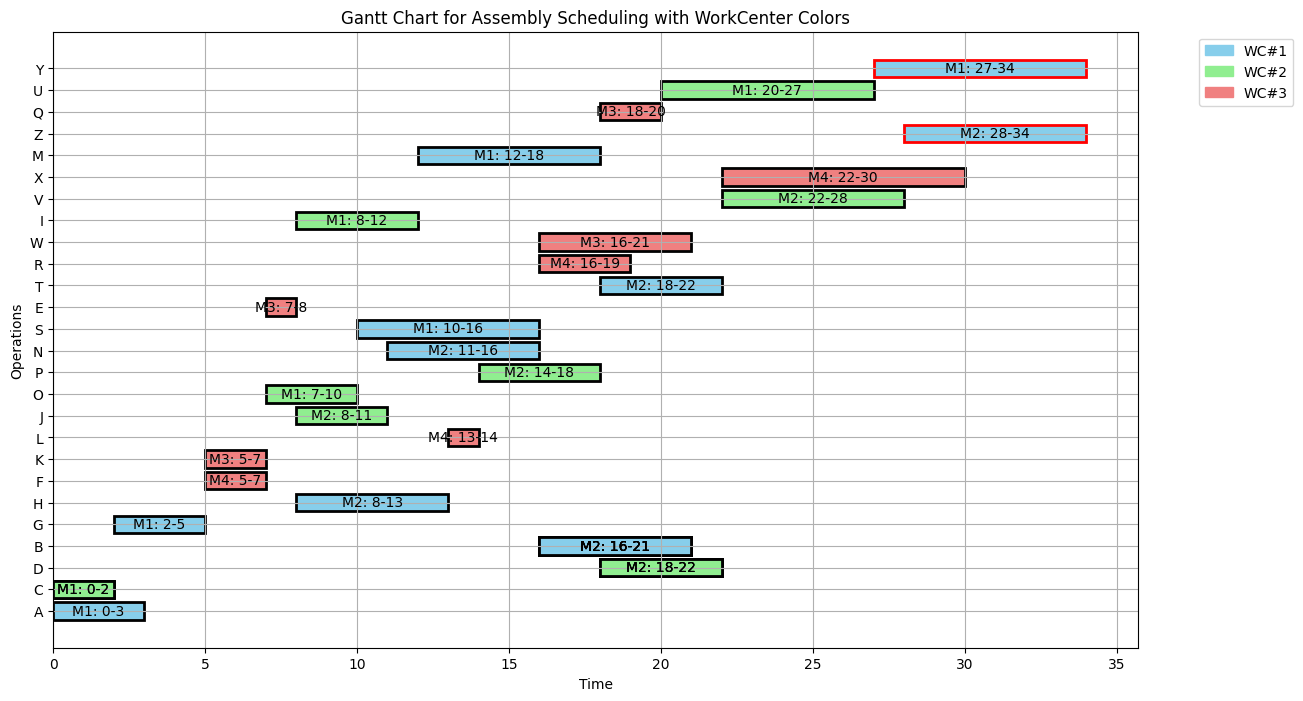

In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import heapq

# Define the Operation class
class Operation:
    def __init__(self, id, processing_time, workcenter, machine, components_required, end_product, due_date):
        self.id = id
        self.processing_time = processing_time
        self.workcenter = workcenter
        self.machine = machine
        self.components_required = components_required if components_required else []
        self.end_product = end_product
        self.due_date = due_date
        self.start_time = None
        self.end_time = None
        self.scheduled = False

# Define the WorkCenter class
class WorkCenter:
    def __init__(self, id, machines_dict={}):
        self.id = id
        self.machines = machines_dict

# Sample DataFrames
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
    'components_required': ['[]', '[]', '[]', '[]', "['A']", "['B']", "['C']", "['D']", "['E']", "['F']", "['G']", "['H']", "['I']", "['J']", "['K']", "['L']", "['M']", "['N']", "['O']", "['P']", "['Q']", "['R']", "['S']", "['T']", "['U']", "['V']"],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    'due_date': [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 40, 40, 40, 40, 20, 20],
    'processing_time': [3, 5, 2, 4, 1, 2, 3, 5, 4, 3, 2, 1, 6, 5, 3, 4, 2, 3, 6, 4, 7, 6, 5, 8, 7, 6],
    'workcenter': ['WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1'],
    'machine': ['M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2']
})

df_machine = pd.DataFrame({
    'workcenter': ['WC#1', 'WC#2', 'WC#3'],
    'M1': [3, 2, 2],
    'M2': [2, 1, 1],
    'M3': [1, 1, 1],
    'M4': [1, 1, 1]
})


# Initialize factory dictionary
factory = {}
for idx, row in df_machine.iterrows():
    workcenter = row['workcenter']
    machines_dict = {machine: [[] for _ in range(row[machine])] for machine in df_machine.columns[1:]}
    factory[workcenter] = WorkCenter(workcenter, machines_dict=machines_dict)

def load_operations_from_df(df):
    operations = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        components_required = eval(row['components_required'])  # Convert string representation of list to list
        operations[operation_id] = Operation(
            operation_id,
            row['processing_time'],
            row['workcenter'],
            row['machine'],
            components_required,
            row['end_product'],
            row['due_date']
        )
    return operations

# Helper function to find the earliest available time slot for a machine
def find_earliest_time_slot(machine_usage, processing_time):
    if not machine_usage:
        return 0
    for i in range(len(machine_usage) - 1):
        if machine_usage[i + 1][0] - machine_usage[i][1] >= processing_time:
            return machine_usage[i][1]
    return machine_usage[-1][1]

# Function to optimize the schedule by minimizing idle time
def optimize_schedule(scheduled_operations, factory):
    for workcenter in factory.values():
        for machine, usage in workcenter.machines.items():
            for idx in range(1, len(usage)):
                prev_end_time = usage[idx - 1][1]
                current_start_time = usage[idx][0]
                if current_start_time > prev_end_time:
                    # Shift the operation to start right after the previous operation
                    shift_amount = current_start_time - prev_end_time
                    usage[idx] = (prev_end_time, usage[idx][1] - shift_amount)
                    # Update the corresponding operation's start and end times
                    for op in scheduled_operations:
                        if op.workcenter == workcenter.id and op.machine == machine and op.start_time == current_start_time:
                            op.start_time -= shift_amount
                            op.end_time -= shift_amount

def schedule_operations(operations):
    scheduled_operations = []
    Q = []
    unscheduled_dependencies = {op_id: len(op.components_required) for op_id, op in operations.items()}
    tardy_operations = []

    # Initialize the queue with operations that have no dependencies, sorted by due dates
    for op_id, count in unscheduled_dependencies.items():
        if count == 0:
            heapq.heappush(Q, (operations[op_id].due_date if operations[op_id].due_date is not None else float('inf'), operations[op_id].processing_time, op_id))

    while Q:
        _, _, operation_id = heapq.heappop(Q)
        operation = operations[operation_id]

        if operation.components_required:
            max_end_time = max(operations[comp_id].end_time for comp_id in operation.components_required)
            operation.start_time = max_end_time
        else:
            operation.start_time = 0

        workcenter = factory[operation.workcenter]
        machine_usage = workcenter.machines[operation.machine]
        best_start_time = float('inf')
        selected_machine = None
        for machine in machine_usage:
            start_time = max(operation.start_time, find_earliest_time_slot(machine, operation.processing_time))
            if start_time < best_start_time:
                best_start_time = start_time
                selected_machine = machine

        operation.start_time = best_start_time
        operation.end_time = operation.start_time + operation.processing_time
        selected_machine.append((operation.start_time, operation.end_time))
        selected_machine.sort()

        operation.scheduled = True
        scheduled_operations.append(operation)
        
        # Debug information
        print(f"Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {operation.machine} in workcenter {operation.workcenter}")

        # Update dependencies and add ready operations to the queue, sorted by due dates
        for op_id, op in operations.items():
            if not op.scheduled and op_id in unscheduled_dependencies:
                for comp_id in op.components_required:
                    if operations[comp_id].scheduled:
                        unscheduled_dependencies[op_id] -= 1
                if unscheduled_dependencies[op_id] == 0:
                    heapq.heappush(Q, (op.due_date if op.due_date is not None else float('inf'), op.processing_time, op_id))

    # Schedule tardy operations after all non-tardy jobs are scheduled
    for operation_id in tardy_operations:
        operation = operations[operation_id]

        if operation.components_required:
            max_end_time = max(operations[comp_id].end_time for comp_id in operation.components_required)
            operation.start_time = max_end_time
        else:
            operation.start_time = 0

        workcenter = factory[operation.workcenter]
        machine_usage = workcenter.machines[operation.machine]
        best_start_time = float('inf')
        selected_machine = None
        for machine in machine_usage:
            start_time = max(operation.start_time, find_earliest_time_slot(machine, operation.processing_time))
            if start_time < best_start_time:
                best_start_time = start_time
                selected_machine = machine

        operation.start_time = best_start_time
        operation.end_time = operation.start_time + operation.processing_time
        selected_machine.append((operation.start_time, operation.end_time))
        selected_machine.sort()

        operation.scheduled = True
        scheduled_operations.append(operation)
        
        # Debug information
        print(f"Tardy Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {operation.machine} in workcenter {operation.workcenter}")

    return scheduled_operations

def plot_gantt_chart(scheduled_operations):
    # Define color mappings
    workcenter_colors = {
        'WC#1': 'skyblue',
        'WC#2': 'lightgreen',
        'WC#3': 'lightcoral'
    }

    fig, ax = plt.subplots(figsize=(14, 8))
    for op in scheduled_operations:
        wc_color = workcenter_colors.get(op.workcenter, 'gray')
        edge_color = 'red' if op.due_date and op.end_time > op.due_date else 'black'
        ax.barh(op.id, op.processing_time, left=op.start_time, color=wc_color, edgecolor=edge_color, linewidth=2)
        ax.text(op.start_time + op.processing_time / 2, op.id, f'{op.machine}: {op.start_time}-{op.end_time}', ha='center', va='center', color='black')

    # Add legend
    workcenter_patches = [mpatches.Patch(color=color, label=wc) for wc, color in workcenter_colors.items()]
    plt.legend(handles=workcenter_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.set_title('Gantt Chart for Assembly Scheduling with WorkCenter Colors')
    plt.grid(True)
    plt.show()

# Load operations from the BOM dataframe
operations = load_operations_from_df(df_BOM)

# Schedule operations
scheduled_operations = schedule_operations(operations)
for op in scheduled_operations:
    print(f"Operation {op.id}: Start Time = {op.start_time}, End Time = {op.end_time}")

# Plot
plot_gantt_chart(scheduled_operations)


Operation A: Scheduled from 0 to 3 on machine M1 in workcenter WC#1
Operation C: Scheduled from 0 to 2 on machine M2 in workcenter WC#2
Operation D: Scheduled from 2 to 6 on machine M2 in workcenter WC#2
Operation D: Scheduled from 6 to 10 on machine M2 in workcenter WC#2
Operation B: Scheduled from 3 to 8 on machine M1 in workcenter WC#1
Operation E: Scheduled from 3 to 4 on machine M3 in workcenter WC#3
Operation G: Scheduled from 8 to 10 on machine M1 in workcenter WC#1
Operation B: Scheduled from 10 to 15 on machine M1 in workcenter WC#1
Operation F: Scheduled from 15 to 18 on machine M3 in workcenter WC#3
Operation I: Scheduled from 10 to 14 on machine M2 in workcenter WC#2
Operation B: Scheduled from 15 to 20 on machine M1 in workcenter WC#1
Operation D: Scheduled from 14 to 18 on machine M2 in workcenter WC#2
Operation J: Scheduled from 18 to 24 on machine M2 in workcenter WC#2
Operation H: Scheduled from 20 to 25 on machine M1 in workcenter WC#1
Operation C: Scheduled from 24 t

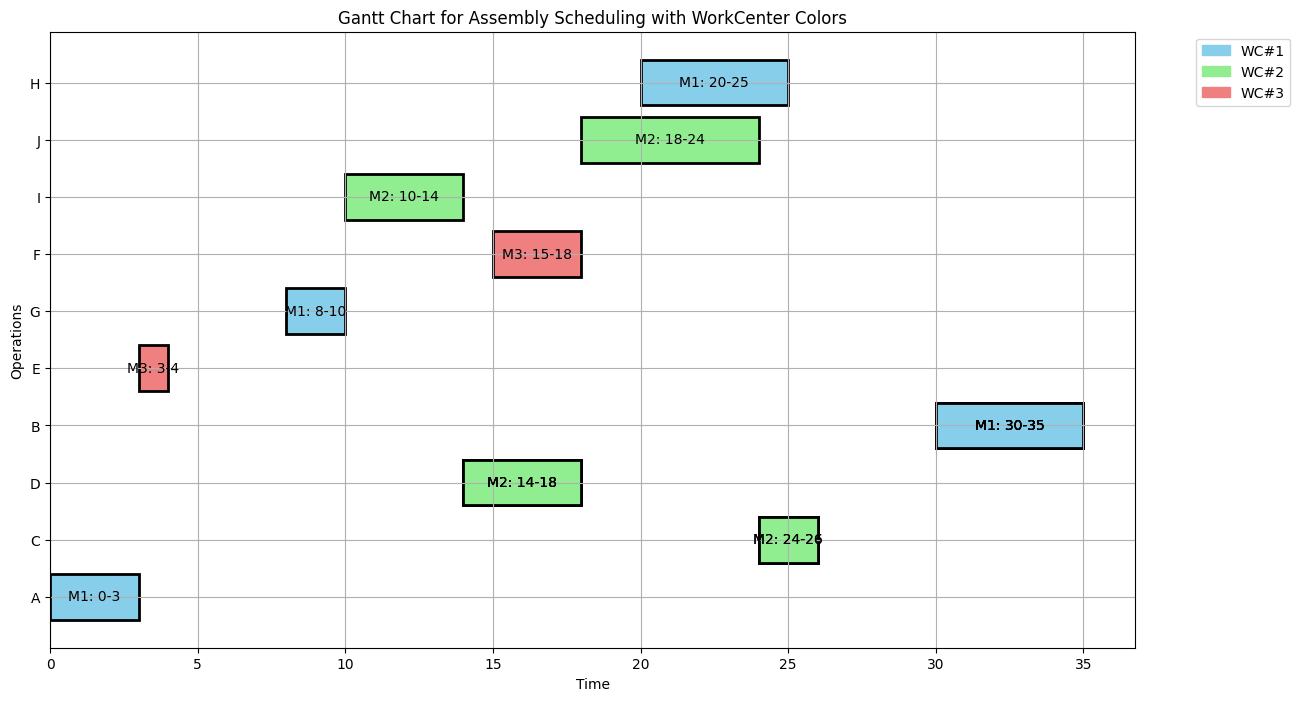

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import heapq

# Define the Operation class
class Operation:
    def __init__(self, id, processing_time, workcenter, machine, components_required, end_product, due_date):
        self.id = id
        self.processing_time = processing_time
        self.workcenter = workcenter
        self.machine = machine
        self.components_required = components_required if components_required else []
        self.end_product = end_product
        self.due_date = due_date
        self.start_time = None
        self.end_time = None
        self.scheduled = False

# Define the WorkCenter class
class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines

# Create BOM DataFrame
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'components_required': ['[]', '[]', '[]', '[]', "['A']", "['B']", "['C']", "['D']", "['E']", "['F']"],
    'end_product': [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    'due_date': [None, None, None, None, 10, 20, 20, 50, 20, 30],
    'processing_time': [3, 5, 2, 4, 1, 3, 2, 5, 4, 6],
    'workcenter': ['WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2'],
    'machine': ['M1', 'M1', 'M2', 'M2', 'M3', 'M3', 'M1', 'M1', 'M2', 'M2']
})

# Modified Machine DataFrame
df_machine = pd.DataFrame({
    'workcenter': ['WC#1', 'WC#2', 'WC#3'],
    'M1': [1, 0, 0],
    'M2': [0, 1, 0],
    'M3': [0, 0, 1],
})

factory = {}
for idx, row in df_machine.iterrows():
    workcenter = row['workcenter']
    dict_machines = {}
    for machine in df_machine.columns[1:]: 
        dict_machines[machine] = [[] for _ in range(row[machine])]
    factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)

def load_operations_from_df(df):
    operations = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        components_required = eval(row['components_required'])  # Convert string representation of list to list
        operations[operation_id] = Operation(
            operation_id,
            row['processing_time'],
            row['workcenter'],
            row['machine'],
            components_required,
            row['end_product'],
            row['due_date']
        )
    return operations

# Helper function to find the earliest available time slot for a machine
def find_earliest_time_slot(machine_usage, processing_time):
    if not machine_usage:
        return 0
    for i in range(len(machine_usage) - 1):
        if machine_usage[i + 1][0] - machine_usage[i][1] >= processing_time:
            return machine_usage[i][1]
    return machine_usage[-1][1]

# Helper function to find the next available start time on the same machine
def find_next_available_start_time(machine_usage, processing_time):
    if not machine_usage:
        return 0
    last_end_time = machine_usage[-1][1]
    return last_end_time

def schedule_operations(operations):
    scheduled_operations = []
    Q = []
    unscheduled_dependencies = {op_id: len(op.components_required) for op_id, op in operations.items()}
    
    # Initialize the queue with operations that have no dependencies, sorted by due dates
    for op_id, count in unscheduled_dependencies.items():
        if count == 0:
            heapq.heappush(Q, (operations[op_id].due_date if operations[op_id].due_date is not None else float('inf'), operations[op_id].processing_time, op_id))

    while Q:
        _, _, operation_id = heapq.heappop(Q)
        operation = operations[operation_id]

        if operation.components_required:
            max_end_time = max(operations[comp_id].end_time for comp_id in operation.components_required)
            operation.start_time = max_end_time
        else:
            operation.start_time = 0

        workcenter = factory[operation.workcenter]
        machine_usage = workcenter.machines[operation.machine]
        best_start_time = float('inf')
        selected_machine = None
        for machine in machine_usage:
            start_time = max(operation.start_time, find_next_available_start_time(machine, operation.processing_time))
            if start_time < best_start_time:
                best_start_time = start_time
                selected_machine = machine

        # If operation is going to be late, push it back
        if operation.due_date and best_start_time + operation.processing_time > operation.due_date:
            for op_id, op in operations.items():
                if not op.scheduled and unscheduled_dependencies[op_id] == 0 and (op.due_date is None or best_start_time + op.processing_time <= op.due_date):
                    heapq.heappush(Q, (op.due_date if op.due_date is not None else float('inf'), op.processing_time, op_id))
            continue

        operation.start_time = best_start_time
        operation.end_time = operation.start_time + operation.processing_time
        selected_machine.append((operation.start_time, operation.end_time))
        selected_machine.sort()

        operation.scheduled = True
        scheduled_operations.append(operation)
        
        # Debug information
        print(f"Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {operation.machine} in workcenter {operation.workcenter}")

        # Update dependencies and add ready operations to the queue, sorted by due dates
        for op_id, op in operations.items():
            if not op.scheduled and op_id in unscheduled_dependencies:
                for comp_id in op.components_required:
                    if operations[comp_id].scheduled:
                        unscheduled_dependencies[op_id] -= 1
                if unscheduled_dependencies[op_id] == 0:
                    heapq.heappush(Q, (op.due_date if op.due_date is not None else float('inf'), op.processing_time, op_id))

    return scheduled_operations

def plot_gantt_chart(scheduled_operations):
    # Define color mappings
    workcenter_colors = {
        'WC#1': 'skyblue',
        'WC#2': 'lightgreen',
        'WC#3': 'lightcoral'
    }

    fig, ax = plt.subplots(figsize=(14, 8))
    for op in scheduled_operations:
        wc_color = workcenter_colors.get(op.workcenter, 'gray')
        edge_color = 'red' if op.due_date and op.end_time > op.due_date else 'black'
        ax.barh(op.id, op.processing_time, left=op.start_time, color=wc_color, edgecolor=edge_color, linewidth=2)
        ax.text(op.start_time + op.processing_time / 2, op.id, f'{op.machine}: {op.start_time}-{op.end_time}', ha='center', va='center', color='black')

    # Add legend
    workcenter_patches = [mpatches.Patch(color=color, label=wc) for wc, color in workcenter_colors.items()]
    plt.legend(handles=workcenter_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.set_title('Gantt Chart for Assembly Scheduling with WorkCenter Colors')
    plt.grid(True)
    plt.show()
# Load operations from the BOM dataframe
operations = load_operations_from_df(df_BOM)

# Schedule operations
scheduled_operations = schedule_operations(operations)
for op in scheduled_operations:
    print(f"Operation {op.id}: Start Time = {op.start_time}, End Time = {op.end_time}")

# Plot the Gantt chart
plot_gantt_chart(scheduled_operations)


# 4. EDD V3

Iteration 1
Operation A: Scheduled from 0 to 3 on machine M1 in workcenter WC#1
Iteration 2
Operation C: Scheduled from 0 to 5 on machine M1 in workcenter WC#2
Iteration 3
Operation D: Scheduled from 0 to 4 on machine M1 in workcenter WC#2
Iteration 4
Operation D: Scheduled from 0 to 4 on machine M2 in workcenter WC#2
Iteration 5
Operation B: Scheduled from 0 to 5 on machine M1 in workcenter WC#1
Iteration 6
Operation G: Scheduled from 5 to 8 on machine M1 in workcenter WC#1
Iteration 7
Operation H: Scheduled from 4 to 9 on machine M1 in workcenter WC#1
Iteration 8
Operation B: Scheduled from 0 to 5 on machine M2 in workcenter WC#1
Iteration 9
Operation F: Scheduled from 5 to 7 on machine M1 in workcenter WC#3
Iteration 10
Operation K: Scheduled from 8 to 10 on machine M1 in workcenter WC#3
Iteration 11
Operation L: Scheduled from 9 to 12 on machine M1 in workcenter WC#3
Iteration 12
Operation B: Scheduled from 0 to 5 on machine M2 in workcenter WC#1
Iteration 13
Operation J: Scheduled

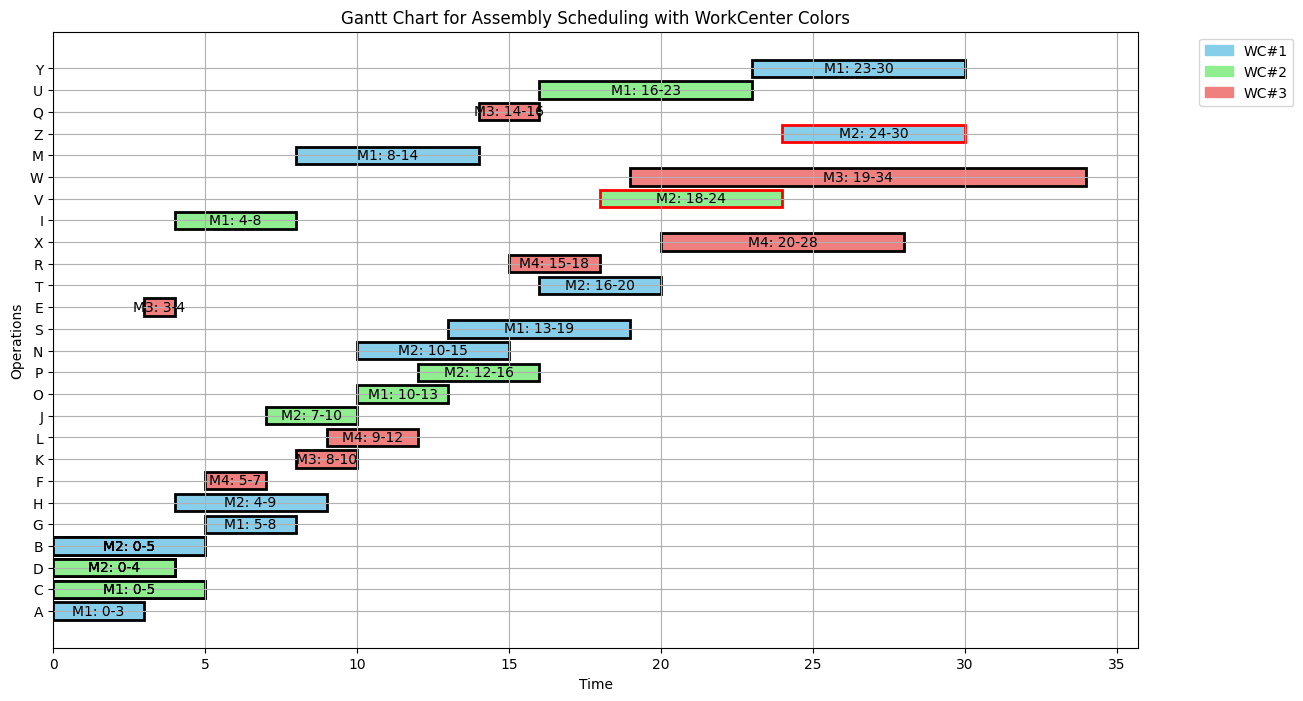

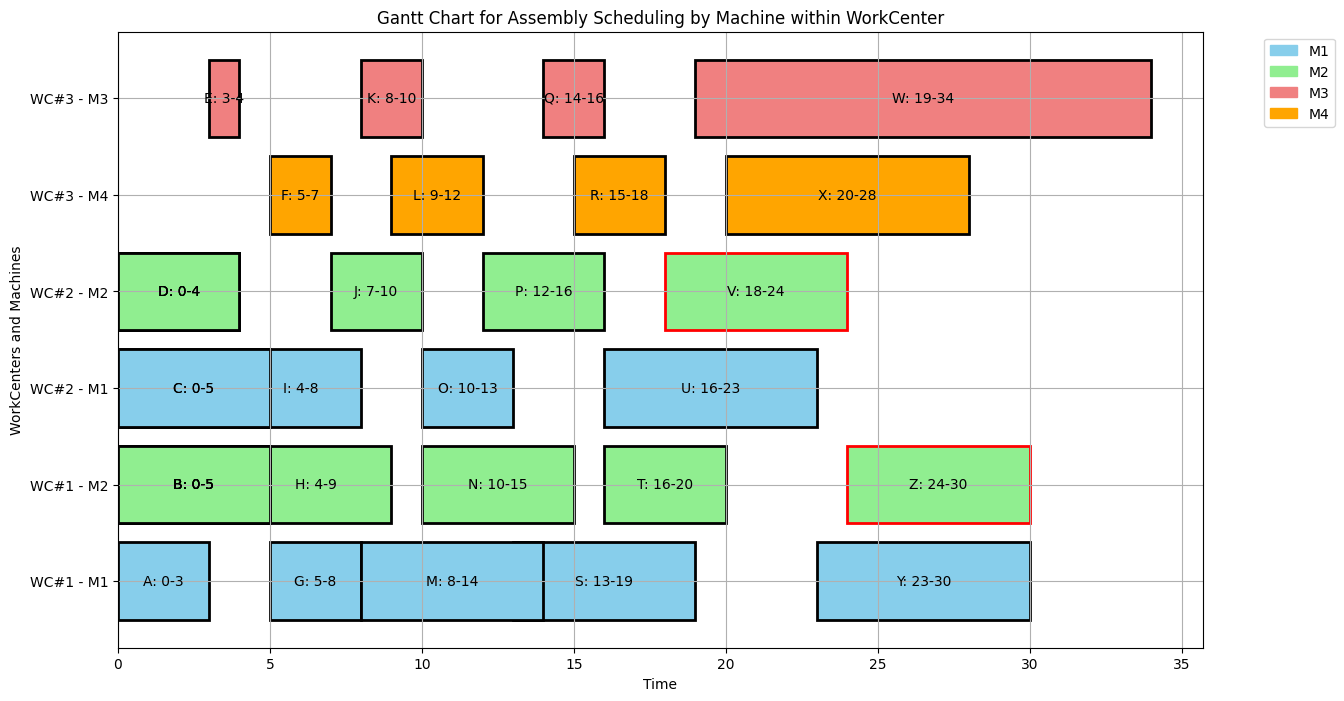

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import heapq

# Define the Operation class
class Operation:
    def __init__(self, id, processing_time, workcenter, machine, components_required, end_product, due_date):
        self.id = id
        self.processing_time = processing_time
        self.workcenter = workcenter
        self.machine = machine
        self.components_required = components_required if components_required else []
        self.end_product = end_product
        self.due_date = due_date
        self.start_time = None
        self.end_time = None
        self.scheduled = False

# Define the WorkCenter class
class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines

# Create BOM DataFrame
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
    'components_required': ['[]', '[]', '[]', '[]', "['A']", "['B']", "['C']", "['D']", "['E']", "['F']", "['G']", "['H']", "['I']", "['J']", "['K']", "['L']", "['M']", "['N']", "['O']", "['P']", "['Q']", "['R']", "['S']", "['T']", "['U']", "['V']"],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    'due_date': [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 40, 20, 40, 40, 40, 20],
    'processing_time': [3, 5, 5, 4, 1, 2, 3, 5, 4, 3, 2, 3, 6, 5, 3, 4, 2, 3, 6, 4, 7, 6, 15, 8, 7, 6],
    'workcenter': ['WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#3', 'WC#3', 'WC#1', 'WC#1'],
    'machine': ['M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2', 'M1', 'M2', 'M3', 'M4', 'M1', 'M2']
})

df_machine = pd.DataFrame({
    'workcenter': ['WC#1', 'WC#2', 'WC#3'],
    'M1': [3, 2, 2],
    'M2': [2, 1, 1],
    'M3': [1, 1, 1],
    'M4': [1, 1, 1]
})

# Create factory and work centers
factory = {}
for idx, row in df_machine.iterrows():
    workcenter = row['workcenter']
    dict_machines = {}
    for machine in df_machine.columns[1:]:
        dict_machines[machine] = [[] for _ in range(row[machine])]
    factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)

def load_operations_from_df(df):
    operations = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        components_required = eval(row['components_required'])  # Convert string representation of list to list
        operations[operation_id] = Operation(
            operation_id,
            row['processing_time'],
            row['workcenter'],
            row['machine'],
            components_required,
            row['end_product'],
            row['due_date']
        )
    return operations

def find_earliest_start_time(machine_usage, start_time, processing_time):
    """
    Finds the earliest start time on the given machine that avoids overlapping with existing jobs.
    """
    if not machine_usage:
        return start_time
    
    for (interval_start, interval_end) in machine_usage:
        if start_time + processing_time <= interval_start:
            return start_time
        start_time = max(start_time, interval_end)
    
    return start_time

def check_availability(start_time, processing_time, machine_usage):
    """
    Returns True if the time interval does not overlap with any intervals in machine_usage, False otherwise.
    """
    end_time = start_time + processing_time
    for interval_start, interval_end in machine_usage:
        if not (end_time <= interval_start or start_time >= interval_end):
            return False
    return True

def schedule_operations(operations):
    scheduled_operations = []
    Q = []
    unscheduled_dependencies = {op_id: len(op.components_required) for op_id, op in operations.items()}
    
    # Initialize the queue with operations that have no dependencies, sorted by due dates
    for op_id, count in unscheduled_dependencies.items():
        if count == 0:
            heapq.heappush(Q, (operations[op_id].due_date if operations[op_id].due_date is not None else float('inf'), operations[op_id].processing_time, op_id))

    i = 1
    while Q:
        print(f"Iteration {i}")
        _, _, operation_id = heapq.heappop(Q)
        operation = operations[operation_id]

        # Compute start time based on dependencies
        if operation.components_required:
            max_end_time = max(operations[comp_id].end_time for comp_id in operation.components_required)
            operation.start_time = max_end_time
        else:
            operation.start_time = 0

        # Find the best machine and start time
        workcenter = factory[operation.workcenter]
        best_start_time = float('inf')
        selected_machine = None
        selected_machine_name = None
        for machine_name, machine_usages in workcenter.machines.items():
            for machine_usage in machine_usages:
                start_time = find_earliest_start_time(machine_usage, operation.start_time, operation.processing_time)
                if check_availability(start_time, operation.processing_time, machine_usage):
                    if start_time < best_start_time:
                        best_start_time = start_time
                        selected_machine = machine_usage
                        selected_machine_name = machine_name

        if selected_machine is None:
            # No available machine found; push operation back
            heapq.heappush(Q, (operation.due_date if operation.due_date is not None else float('inf'), operation.processing_time, operation_id))
            continue

        # Schedule the operation
        operation.start_time = best_start_time
        operation.end_time = operation.start_time + operation.processing_time
        selected_machine.append((operation.start_time, operation.end_time))
        selected_machine.sort()

        # Debug information
        print(f"Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {selected_machine_name} in workcenter {operation.workcenter}")

        operation.scheduled = True
        scheduled_operations.append(operation)

        # Update dependencies and add ready operations to the queue
        for op_id, op in operations.items():
            if not op.scheduled and op_id in unscheduled_dependencies:
                for comp_id in op.components_required:
                    if operations[comp_id].scheduled:
                        unscheduled_dependencies[op_id] -= 1
                if unscheduled_dependencies[op_id] == 0:
                    heapq.heappush(Q, (op.due_date if op.due_date is not None else float('inf'), op.processing_time, op_id))
        i += 1



        

    return scheduled_operations

def plot_gantt_chart(scheduled_operations):
    # Define color mappings
    workcenter_colors = {
        'WC#1': 'skyblue',
        'WC#2': 'lightgreen',
        'WC#3': 'lightcoral'
    }

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(14, 8))
    for op in scheduled_operations:
        wc_color = workcenter_colors.get(op.workcenter, 'gray')
        edge_color = 'red' if op.due_date and op.end_time > op.due_date else 'black'
        ax.barh(op.id, op.processing_time, left=op.start_time, color=wc_color, edgecolor=edge_color, linewidth=2)
        ax.text(op.start_time + op.processing_time / 2, op.id, f'{op.machine}: {op.start_time}-{op.end_time}', ha='center', va='center', color='black')

    # Add legend
    workcenter_patches = [mpatches.Patch(color=color, label=wc) for wc, color in workcenter_colors.items()]
    plt.legend(handles=workcenter_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.set_title('Gantt Chart for Assembly Scheduling with WorkCenter Colors')
    plt.grid(True)
    plt.show()

def plot_gantt_chart_by_workcenter(scheduled_operations):
    # Define color mappings
    machine_colors = {
        'M1': 'skyblue',
        'M2': 'lightgreen',
        'M3': 'lightcoral',
        'M4': 'orange'
    }

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Group operations by work center and machine
    workcenter_machine_ops = {}
    for op in scheduled_operations:
        wc = op.workcenter
        machine = op.machine
        if wc not in workcenter_machine_ops:
            workcenter_machine_ops[wc] = {}
        if machine not in workcenter_machine_ops[wc]:
            workcenter_machine_ops[wc][machine] = []
        workcenter_machine_ops[wc][machine].append(op)
    
    # Initialize y-axis labels and offsets
    y_labels = []
    y_offset = 0  # To manage vertical spacing between machines
    for wc, machines in workcenter_machine_ops.items():
        for machine, ops in machines.items():
            y_labels.append(f'{wc} - {machine}')
            for op in ops:
                machine_color = machine_colors.get(op.machine, 'orange')
                edge_color = 'red' if op.due_date and op.end_time > op.due_date else 'black'
                ax.barh(y_offset, op.processing_time, left=op.start_time, color=machine_color, edgecolor=edge_color, linewidth=2)
                ax.text(op.start_time + op.processing_time / 2, y_offset, f'{op.id}: {op.start_time}-{op.end_time}', ha='center', va='center', color='black')
            y_offset += 1  # Move to the next row for the next machine in the same work center

    # Set y-axis labels
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)
    
    # Add legend
    machine_patches = [mpatches.Patch(color=color, label=machine) for machine, color in machine_colors.items()]
    plt.legend(handles=machine_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xlabel('Time')
    ax.set_ylabel('WorkCenters and Machines')
    ax.set_title('Gantt Chart for Assembly Scheduling by Machine within WorkCenter')
    plt.grid(True)
    plt.show()

# Load operations from the DataFrame
operations = load_operations_from_df(df_BOM)

# Schedule the operations
scheduled_operations = schedule_operations(operations)

# Plot the Gantt charts
plot_gantt_chart(scheduled_operations)
plot_gantt_chart_by_workcenter(scheduled_operations)
